In [1]:
%matplotlib inline
import pandas as pd

In [2]:
compras_df=pd.read_csv('data/clean_compras.csv')

In [3]:
data=compras_df.copy()

# LLenar los valores faltantes del DF

In [5]:
for i,column in enumerate(list([str(d) for d in data.dtypes])):
    if column =="object":
        data[data.columns[i]]=data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]]=data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]]=data[data.columns[i]].fillna(data[data.columns[i]].median())

# Utilizar Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
y=data.pop('IMPORTE')

In [14]:
X=data.copy()

In [15]:
X

,C B,BENEFICIARIO,RFC,FACTURAS,CONTRATO,CONCEPTO,TIPO,FDO-#OP,FECHA,SHEET
0,110036,460,468,636,703,601,1,1029007.0,12,2
1,111017,377,387,2309,771,2260,1,1029028.0,12,2
2,112917,503,503,7,5,2107,1,1028981.0,10,2
3,112917,503,503,6,5,2108,1,1029062.0,14,2
4,113290,105,72,899,85,237,1,1029036.0,12,2
...,...,...,...,...,...,...,...,...,...,...
2657,203016,515,514,26,5,1132,0,351001069.0,7,3
2658,203016,515,514,29,5,1133,0,351001146.0,12,3
2659,203016,515,514,28,5,1131,0,351001154.0,12,3
2660,203016,521,522,30,5,1149,0,351001106.0,8,3


# Dividir los datos en grupos

In [17]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.33, random_state=42)

In [18]:
clf= RandomForestRegressor(n_estimators=1000, max_depth=4)

In [19]:
clf.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [20]:
from sklearn.metrics import r2_score

In [21]:
r2_score(y_test, clf.predict(X_test))

0.11523835584527808

# Modelo No Supervisado

In [23]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning, module="sklearn")
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [24]:
compras_df_c=compras_df.copy()

In [25]:
compras_df_c_grupo=compras_df_c.groupby('BENEFICIARIO').agg({'CONTRATO': lambda x: x.nunique(), 'IMPORTE': 'sum',
                                                            'FACTURAS': lambda x: x.nunique()})

In [26]:
compras_df_cluster=compras_df_c_grupo.reset_index()

In [27]:
compras_df_cluster

,BENEFICIARIO,CONTRATO,IMPORTE,FACTURAS
0,"8ENRED, S DE R.L. DE C.V.",1,638000.00,1
1,ABUNDIS ALBERTO,1,47696.25,1
2,"ACOPIADORA COMERCIAL Y AGROINDUSTRIAL, S.A. DE...",10,823499.96,10
3,ADAME FARIAS ADOLFO,12,1408444.16,12
4,"ADMON DE PROY Y SERVICIOS EN CONDOMINIO, SC.",3,149762.63,4
...,...,...,...,...
531,"W40, S.A. DE C.V.",1,21576.00,1
532,"YAPAU CONSULTING, S DE R.L. DE C.V.",1,500000.00,1
533,ZAPATA CHAVIRA HOMERO ARTURO,1,26730.00,1
534,ZARAZUA BUSTOS JAVIER,1,719896.00,1


In [28]:
compras_df_c_grupo_f=compras_df_c_grupo.reset_index().drop(['BENEFICIARIO'], axis=1)

In [38]:
normalizado_compras_df=(compras_df_c_grupo_f - compras_df_c_grupo_f.min())/(compras_df_c_grupo_f.max()-compras_df_c_grupo_f.min())

In [40]:
normalizado_compras_df

,CONTRATO,IMPORTE,FACTURAS
0,0.000000,0.002105,0.000000
1,0.000000,0.000156,0.000000
2,0.089109,0.002718,0.016822
3,0.108911,0.004649,0.020561
4,0.019802,0.000493,0.005607
...,...,...,...
531,0.000000,0.000070,0.000000
532,0.000000,0.001650,0.000000
533,0.000000,0.000087,0.000000
534,0.000000,0.002376,0.000000


In [42]:
wcss=[]

In [44]:
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(normalizado_compras_df)
    wcss.append(kmeans.inertia_)

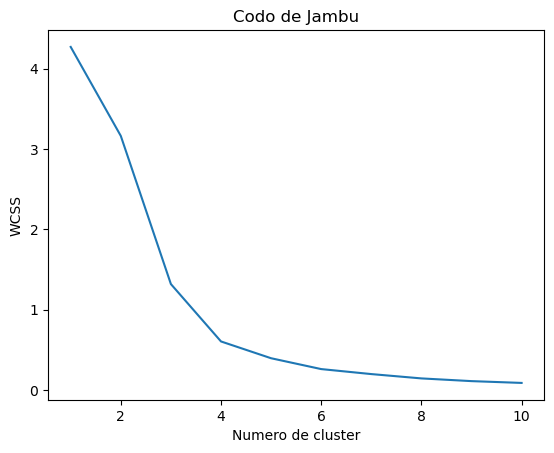

In [45]:
plt.plot(range(1,11), wcss)
plt.title('Codo de Jambu')
plt.xlabel('Numero de cluster')
plt.ylabel('WCSS')  #Indica lacantidad de similitud de los individuos
plt.show()

In [46]:
clustering=KMeans(n_clusters=3, max_iter=300)

In [47]:
clustering.fit(normalizado_compras_df)

KMeans(n_clusters=3)

In [48]:
compras_df_cluster['KMeans_Cluster']=clustering.labels_

In [49]:
compras_df_cluster['KMeans_Cluster'].value_counts()

KMeans_Cluster
0    534
1      1
2      1
Name: count, dtype: int64

In [50]:
from sklearn.decomposition import PCA

In [51]:
pca=PCA(n_components=2)

In [52]:
pca_compras=pca.fit_transform(normalizado_compras_df)

In [54]:
pca_compras_df=pd.DataFrame(data=pca_compras, columns=['componente_1', 'componente_2'])

In [55]:
pca_nombres_beneficia=pd.concat([pca_compras_df, compras_df_cluster['KMeans_Cluster']], axis=1)

In [58]:
pca_nombres_beneficia

,componente_1,componente_2,KMeans_Cluster
0,-0.016936,-0.005057,0
1,-0.017040,-0.006998,0
2,0.066088,-0.011707,0
3,0.084633,-0.011398,0
4,0.002472,-0.008209,0
...,...,...,...
531,-0.017044,-0.007084,0
532,-0.016960,-0.005511,0
533,-0.017043,-0.007067,0
534,-0.016922,-0.004788,0


In [68]:
plt.figure(figsize=(10,8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

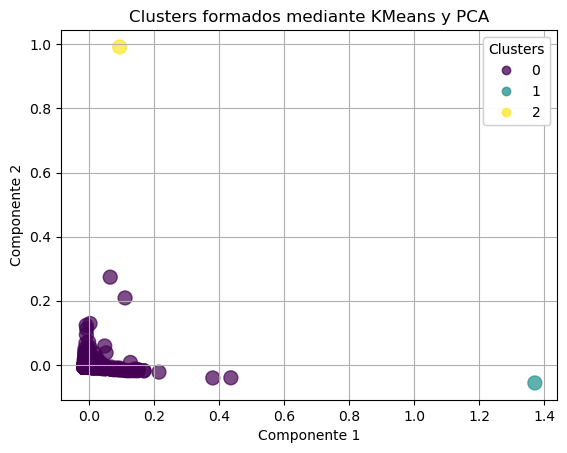

In [69]:
scatter=plt.scatter(pca_nombres_beneficia['componente_1'],
                   pca_nombres_beneficia['componente_2'],
                   c=pca_nombres_beneficia['KMeans_Cluster'],
                   cmap='viridis',
                   s=100,
                   alpha=0.7)

#Añadir el titulo y etiquetas
plt.title('Clusters formados mediante KMeans y PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
legend1=plt.legend(*scatter.legend_elements(), title='Clusters')
plt.gca().add_artist(legend1)
plt.grid()
plt.show()